In [1]:
from _util import *
import _discrete as discrete
import _analyze as analyze
reload(discrete)

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

################################################
data_existed = 1
gamma = 0.95 # 0.99
pi1 = pi = discrete.toy_pi()
################################################
if not data_existed:
    N = 10000
    T = 200 #1000
    
    simu_circle = discrete.simuCricle(gamma = gamma, pi = pi) 
    trajs_behav, details_behav = simu_circle.simu_trajs(N, T, policy = "behav")
    trajs_tp, details_tp = simu_circle.simu_trajs(N, T, policy = "tp")

    ################################################
    omega = simu_circle.get_omega(details_behav, details_tp)
    V_true, V_true_std = simu_circle.get_V(details_tp[2])

    printR("true_V = {:.3f} with std = {:.3f}".format(V_true, V_true_std))
    ################################################
    omega_star = []
    Q = np.zeros((3, 2))

    for S in [0, 1, 2]:
        omega_star_fixed_S = []
        for A in [-1, 1]:
            init_SA = [S, A]
            a = now()
            trajs_tp, details_tp = simu_circle.simu_trajs(N, T, policy = "tp", init_SA = init_SA)
            omega = simu_circle.get_omega(details_behav, details_tp)
            omega_star_fixed_S.append(omega)
            Q[S, (A + 1) // 2], std_Q = simu_circle.get_V(details_tp[2])
            print(S, A, "DONE! with mean = {:.3f} and std = {:.3f}".format(Q[S, (A + 1) // 2], std_Q))
        omega_star.append(omega_star_fixed_S)
    omega_star = np.array(omega_star)
    toy_data = {"V_true" : V_true
               , "Q" : Q
               , "omega" : omega
               , "omega_star" : omega_star}
    # dump(toy_data, "toy_data")
else:
    toy_data = load("res/toy_data_095")
#     toy_data = load("res/toy_data")
    V_true = toy_data["V_true"]
    Q = toy_data["Q"]
    omega = toy_data["omega"]
    omega_star = toy_data["omega_star"]


In [168]:
reload(discrete)
incomplete_ratio = None

rep = 200

################################################
T = 50
Q_ratio =  5
omega_ratio = 25 #25
omega_star_ratio = 25
init_size = 2000
################################################     
res_all = []


seed = 0
np.random.seed(seed)
printR("<<<<<<<<<< T = {}, Q_ratio = {}, omega_ratio = {}, init_S = {}>>>>>>>>>>>".format(T
                                                                                          , Q_ratio, omega_ratio, init_size))
res_diff_rate = []
for rate in [-1/2, -1/4, -1/6]:
    printG("rate = {}".format(rate))
    N_range = np.arange(50, 500, 50)
    res_this = []
    for N in N_range:
        if N <= 200:
            n_gpu = 100
        elif N <= 400:
            n_gpu = 50
        else:
            n_gpu = 20
        printR("\n N = {}".format(N))
        ray.shutdown()
        simu_circle = discrete.simuCricle(gamma = gamma, pi = pi) 

        a = now()
        rec = analyze.recorder()

        for i in range(rep // n_gpu):
            @ray.remote # num_cpus=1 # ()
            def one_seed1(seed):
                reload(discrete)
                os.environ["OMP_NUM_THREADS"] = "1"
                os.environ["MKL_NUM_THREADS"] = "1"
                os.environ["OPENBLAS_NUM_THREADS"] = "1"
                os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
                os.environ["NUMEXPR_NUM_THREADS"] = "1"

                np.random.seed(seed)
                ###############################################
                Q_error = Q + randn(3, 2) / Q_ratio * (N ** (rate))

                omega_error = omega + randn(3, 2) / omega_ratio * (N ** (rate))
                omega_error /= np.mean(omega_error)
                omega_star_error = omega_star.copy()
                for s in range(3):
                    for a in range(2):
                        omega_star_error[s][a] = omega_star[s][a] + randn(3, 2) / omega_star_ratio * (N ** (rate))
                        omega_star_error[s][a] /= np.mean(omega_star_error[s][a])

                Q_used = Q_error.copy()
                omega_used = omega_error.copy()
                omega_star_used = omega_star_error.copy()
                ############################
                true_Q = discrete.TrueQ(Q_used)
                true_omega = discrete.TrueOmega(omega_used)
                true_omega_star = discrete.TrueOmega_star(omega_star_used)
                ####################################################################################


                trajs_train, _ = simu_circle.simu_trajs(N, T, policy = "behav", seed = seed)
                gpu_idx = 0
                # ############################ TRIPLE to estimate values ############################
                are = discrete.ARE_discrete(trajs_train, pi = pi1, gamma = gamma, gpu_number = gpu_idx, incomplete_ratio = incomplete_ratio, L = 2
                                , sepe_A = True)
                init_S = np.random.choice(a = 3, size = init_size, p = [1 / 3, 1 / 3, 1 / 3])
                are.init_S = init_S 
                are.load_true(true_Q, true_omega, true_omega_star)
                are.est_double_robust()
                are.est_triply_robust()  
                are.est_quad_robust()
                #######
                return [are.raw_Qs, are.DR_V, are.TR_V, are.QR_V]
            ray.init()
            ###########
            futures = [one_seed1.remote(j) for j in range(n_gpu * i, n_gpu * (i + 1))]
            res = ray.get(futures)
            for j in range(n_gpu):
                rec.update(V_true, are_details = res[j])
    #         rec.analyze()
            ray.shutdown()
        rec.analyze()
        res_this.append(rec)
    res_diff_rate.append(res_this)
res_all.append(res_diff_rate)
res_all3 = res_all

<<<<<<<<<< T = 50, Q_ratio = 5, omega_ratio = 25, init_S = 2000>>>>>>>>>>>
rate = -0.5

 N = 50


2020-12-10 00:07:51,132	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:07:57,351	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.095,0.076,0.032,0.092,0.960,0.890
TR,0.085,0.068,-0.006,0.085,0.955,0.875
QR,0.086,0.068,-0.001,0.085,0.960,0.890


Q: RMSE = 0.18, bias = 0.18
rep = 200

 N = 100


2020-12-10 00:08:03,525	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:08:13,001	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.064,0.051,2.368e-02,0.063,0.94,0.88
TR,0.058,0.045,6.136e-04,0.060,0.96,0.89
QR,0.058,0.045,2.900e-03,0.060,0.96,0.89


Q: RMSE = 0.18, bias = 0.18
rep = 200

 N = 150


2020-12-10 00:08:22,513	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:08:35,576	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.056,0.044,0.024,0.051,0.90,0.870
TR,0.050,0.039,0.002,0.049,0.93,0.865
QR,0.050,0.039,0.003,0.049,0.93,0.860


Q: RMSE = 0.17, bias = 0.17
rep = 200

 N = 200


2020-12-10 00:08:48,634	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:09:08,090	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.048,0.038,0.022,0.044,0.915,0.860
TR,0.042,0.033,0.003,0.042,0.920,0.885
QR,0.042,0.033,0.004,0.042,0.920,0.890


Q: RMSE = 0.17, bias = 0.17
rep = 200

 N = 250


2020-12-10 00:09:27,277	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:09:42,851	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:09:59,198	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:10:13,657	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.044,0.035,0.019,0.039,0.920,0.870
TR,0.039,0.030,0.001,0.038,0.925,0.870
QR,0.039,0.031,0.002,0.038,0.920,0.885


Q: RMSE = 0.17, bias = 0.17
rep = 200

 N = 300


2020-12-10 00:10:29,032	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:10:48,581	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:11:08,084	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:11:26,457	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.040,0.033,0.019,0.036,0.905,0.855
TR,0.035,0.028,0.003,0.034,0.930,0.875
QR,0.035,0.028,0.004,0.035,0.930,0.875


Q: RMSE = 0.17, bias = 0.17
rep = 200

 N = 350


2020-12-10 00:11:45,329	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:12:09,640	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:12:34,377	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:12:59,116	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.038,0.031,0.019,0.033,0.920,0.845
TR,0.033,0.027,0.003,0.032,0.945,0.885
QR,0.033,0.027,0.004,0.032,0.945,0.885


Q: RMSE = 0.17, bias = 0.17
rep = 200

 N = 400


2020-12-10 00:13:23,993	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:13:53,945	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:14:23,821	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:14:53,910	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.036,0.030,0.018,0.031,0.920,0.825
TR,0.031,0.025,0.003,0.030,0.935,0.880
QR,0.031,0.025,0.004,0.030,0.940,0.880


Q: RMSE = 0.17, bias = 0.17
rep = 200

 N = 450


2020-12-10 00:15:25,007	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:15:49,513	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:16:12,612	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:16:41,869	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:17:10,911	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8267
2020-12-10 00:17:40,313	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:18:11,493	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:18:33,707	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:18:56,251	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:19:18,612	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.035,0.029,0.017,0.029,0.890,0.820
TR,0.031,0.025,0.003,0.028,0.925,0.855
QR,0.031,0.025,0.003,0.028,0.920,0.860


Q: RMSE = 0.17, bias = 0.17
rep = 200
rate = -0.25

 N = 50


2020-12-10 00:19:40,464	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:19:46,700	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.128,0.105,0.074,0.115,0.930,0.865
TR,0.098,0.080,-0.043,0.086,0.915,0.810
QR,0.088,0.071,-0.009,0.089,0.965,0.880


Q: RMSE = 0.23, bias = 0.23
rep = 200

 N = 100


2020-12-10 00:19:52,875	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:20:02,459	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.093,0.079,0.067,0.076,0.885,0.845
TR,0.063,0.049,-0.021,0.060,0.940,0.890
QR,0.060,0.046,0.003,0.062,0.960,0.900


Q: RMSE = 0.22, bias = 0.22
rep = 200

 N = 150


2020-12-10 00:20:11,898	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:20:24,949	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.091,0.078,0.072,0.061,0.815,0.705
TR,0.055,0.043,-0.019,0.049,0.890,0.860
QR,0.051,0.040,0.003,0.050,0.935,0.875


Q: RMSE = 0.21, bias = 0.21
rep = 200

 N = 200


2020-12-10 00:20:38,375	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:20:57,420	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.084,0.074,0.070,0.052,0.790,0.635
TR,0.045,0.036,-0.013,0.042,0.940,0.885
QR,0.043,0.034,0.006,0.043,0.945,0.895


Q: RMSE = 0.21, bias = 0.21
rep = 200

 N = 250


2020-12-10 00:21:16,707	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:21:31,926	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:21:46,319	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:22:02,433	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.080,0.071,0.068,0.046,0.695,0.545
TR,0.041,0.032,-0.013,0.038,0.910,0.850
QR,0.039,0.031,0.005,0.039,0.935,0.900


Q: RMSE = 0.21, bias = 0.21
rep = 200

 N = 300


2020-12-10 00:22:17,838	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:22:40,963	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:23:06,147	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8267
2020-12-10 00:23:31,130	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8267


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.077,0.069,0.068,0.041,0.665,0.46
TR,0.037,0.028,-0.010,0.035,0.930,0.88
QR,0.036,0.029,0.006,0.035,0.955,0.87


Q: RMSE = 0.20, bias = 0.20
rep = 200

 N = 350


2020-12-10 00:23:54,632	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8267
2020-12-10 00:24:26,860	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8267
2020-12-10 00:25:00,507	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8267
2020-12-10 00:25:28,439	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.076,0.068,0.068,0.038,0.560,0.430
TR,0.034,0.027,-0.008,0.032,0.925,0.875
QR,0.034,0.028,0.008,0.032,0.955,0.895


Q: RMSE = 0.20, bias = 0.20
rep = 200

 N = 400


2020-12-10 00:25:53,056	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:26:23,902	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:26:54,695	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:27:25,774	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.074,0.067,0.067,0.035,0.505,0.395
TR,0.032,0.026,-0.008,0.030,0.920,0.860
QR,0.032,0.026,0.007,0.030,0.940,0.870


Q: RMSE = 0.20, bias = 0.20
rep = 200

 N = 450


2020-12-10 00:28:03,474	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:28:34,130	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:29:04,257	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:29:34,702	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:29:59,685	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:30:21,254	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:30:42,535	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:31:04,884	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:31:27,460	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:31:50,510	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.073,0.066,0.065,0.033,0.475,0.34
TR,0.032,0.025,-0.009,0.028,0.920,0.86
QR,0.031,0.025,0.006,0.029,0.910,0.85


Q: RMSE = 0.20, bias = 0.20
rep = 200
rate = -0.16666666666666666

 N = 50


2020-12-10 00:32:21,477	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:32:30,101	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.153,0.128,0.099,0.133,0.925,0.86
TR,0.122,0.102,-0.078,0.091,0.830,0.79
QR,0.091,0.073,-0.010,0.094,0.970,0.89


Q: RMSE = 0.25, bias = 0.25
rep = 200

 N = 100


2020-12-10 00:32:37,806	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:32:47,800	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.118,0.102,0.095,0.089,0.875,0.765
TR,0.079,0.065,-0.048,0.062,0.875,0.790
QR,0.062,0.048,0.007,0.065,0.955,0.890


Q: RMSE = 0.24, bias = 0.24
rep = 200

 N = 150


2020-12-10 00:32:58,097	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:33:13,864	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.122,0.109,0.106,0.070,0.700,0.55
TR,0.072,0.059,-0.047,0.050,0.840,0.73
QR,0.053,0.041,0.006,0.052,0.935,0.89


Q: RMSE = 0.24, bias = 0.24
rep = 200

 N = 200


2020-12-10 00:33:30,086	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:33:54,202	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.118,0.108,0.107,0.060,0.575,0.415
TR,0.060,0.049,-0.038,0.043,0.845,0.735
QR,0.044,0.036,0.011,0.045,0.945,0.905


Q: RMSE = 0.24, bias = 0.23
rep = 200

 N = 250


2020-12-10 00:34:19,445	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:34:35,093	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:34:50,443	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:35:05,938	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.114,0.105,0.105,0.053,0.48,0.330
TR,0.055,0.045,-0.038,0.038,0.82,0.740
QR,0.040,0.032,0.010,0.040,0.94,0.905


Q: RMSE = 0.24, bias = 0.24
rep = 200

 N = 300


2020-12-10 00:35:21,310	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:35:40,973	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:36:00,171	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:36:19,655	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.111,0.105,0.105,0.048,0.405,0.225
TR,0.050,0.039,-0.034,0.035,0.845,0.755
QR,0.037,0.030,0.011,0.036,0.960,0.870


Q: RMSE = 0.23, bias = 0.23
rep = 200

 N = 350


2020-12-10 00:36:44,898	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8267
2020-12-10 00:37:17,639	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8267
2020-12-10 00:37:49,327	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8267
2020-12-10 00:38:21,015	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8267


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.113,0.106,0.106,0.044,0.295,0.185
TR,0.045,0.036,-0.030,0.032,0.820,0.745
QR,0.036,0.030,0.013,0.034,0.955,0.865


Q: RMSE = 0.23, bias = 0.23
rep = 200

 N = 400


2020-12-10 00:38:54,346	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8267
2020-12-10 00:39:24,255	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:39:54,222	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:40:25,915	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.111,0.105,0.105,0.041,0.225,0.120
TR,0.044,0.035,-0.030,0.030,0.815,0.725
QR,0.034,0.027,0.012,0.031,0.940,0.850


Q: RMSE = 0.23, bias = 0.23
rep = 200

 N = 450


2020-12-10 00:40:56,843	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:41:18,975	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:41:40,345	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:42:02,808	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:42:25,151	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:42:47,626	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:43:09,973	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:43:32,209	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:43:54,738	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266
2020-12-10 00:44:24,159	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


,RMSE,MAE,bias,ave_std,freq: 0.95,freq: 0.9
DR,0.110,0.105,0.105,0.038,0.190,0.115
TR,0.044,0.035,-0.030,0.028,0.775,0.715
QR,0.033,0.027,0.010,0.029,0.910,0.840


Q: RMSE = 0.23, bias = 0.23
rep = 200


In [169]:
final_res = arr([[[mean(a.DR['freq']['10'])
, mean(a.TR['freq']['10'])
, mean(a.QR['freq']['10'])] for a in b] for b in res_all3[0]])

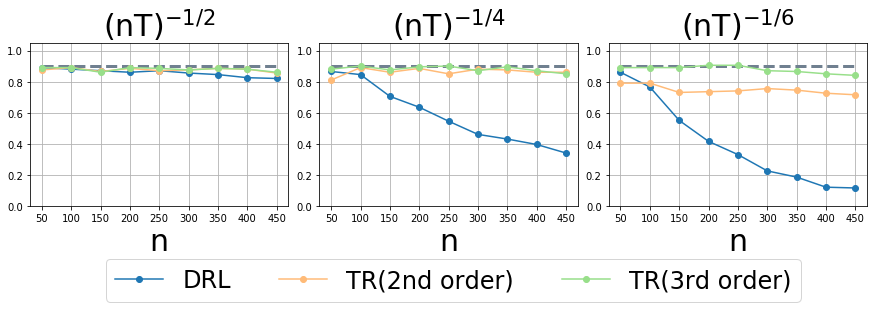

In [7]:
import _plot as plot
from matplotlib.transforms import BlendedGenericTransform

marker = "o"
xlabel = "n"
############################################
X_range = np.arange(50, 500, 50)
labels = ['DRL', 'TR(2nd order)', 'TR(3rd order)']

fig, axs = plt.subplots(1, 3,figsize=(15,3))
plt.subplots_adjust(wspace = .12)

rates = [r"$(nT)^{-1/2}$", r"$(nT)^{-1/4}$", r"$(nT)^{-1/6}$"]
y_lab = [None, None, None] # "frequency"
for i in range(3):
    ax09, legends09 = plot.plot_curves(final_res[i].T, horizontal = 0.9, x_axis = X_range, title = rates[i]
              , labels = labels, legend_title = "Method"
              , y_high = 1.05, y_low = 0, marker = marker
              , title_size = 30, x_label_size = 30, y_label_size = 26
              , xlabel = xlabel, y_lab = y_lab[i], path = None
             , ax = axs[i], is_sub_plot = True, print_legend = False)


leg = fig.legend(
          legends09 + [ax09.get_legend_handles_labels()[0][-1]]    # The line objects
      , labels= labels   # The labels for each line
        , bbox_to_anchor = [0.85, -0.25] # location
    , ncol=3, numpoints=1
    , fontsize = 24
        , bbox_transform = BlendedGenericTransform(fig.transFigure, ax09.transAxes)
)


fig.show()

fig.savefig("final_plot/plot/" + "toy_CI_new.png"
           ,  bbox_extra_artists=(leg,), bbox_inches='tight')
